## Goals: Training the _Final_ Models

This notebook trains the model on the full _baseline_dataset_ for the final prediction on evaluation data.

Here, we train a model designed to generalize across water stations in Brazil and France. However, you are not required to follow this approach and may opt to train separate models for different geographic _regions_.

This baseline model training example utilizes all available features, with hyperparameters chosen for quick execution rather than optimization. For hyperparameter tuning and feature selection explorations, refer to the `02_exploration` folder.

> **Note:** This notebook requires outputs from the `00 Preprocessing` notebooks.

<img src="../images/notebook-3.png" alt="Experiment Diagram" style="width:75%; text-align:center;" />

### 1. Data Import and Setup

This section imports the necessary libraries, sets up environment paths, and includes custom utility functions.


In [1]:
import os
import sys

import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
import lightgbm as lgb

from interpret.glassbox import ExplainableBoostingRegressor
from mapie.regression import MapieQuantileRegressor
from quantile_forest import RandomForestQuantileRegressor

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..")))

from src.utils.model import (
    split_dataset,
    compare_models_per_station,
    Ensemble
)

from src.utils.helpers import check_columns_exist

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

##### Constants :

- **INPUT_DIR**: Directory for input data (same as in "02 - Feature Engineering").
- **MODEL_DIR**: Directory where trained models are saved.
- **DATASET_DIR**: Directory where the Zenodo dataset is unzipped.

##### Model Parameters

- **SEED**: 42 (for reproducibility)
- **NUMBER_OF_WEEK**: 4 (one model is trained per week)

##### FINAL_MODELS

- **qrf**: Quantile Random Forest (natively produces prediction intervals) - **Baseline model**.
- **ensemble**: An ensemble of `XGBQRF` custom models where each model is trained on a region and a third model is trained on the entire dataset. The final prediction is a weighted average of the models based on the inputs.


In [2]:
INPUT_DIR = "../../../data/input/"
DATASET_DIR = "../../../dataset/"

# This list should be the same as the one used in the previous notebook as it will be used to fetch the data
DATASET_TRANSFORMS = [
    "rm_gnv_st",  # Remove the geneva station (which is an outlier in the dataset) - Recommended
    "pca",  # Apply PCA to some of the static features (soil composition etc...) - Recommended
    "snow_index",  # Compute the snow index - probability of snow (which is a feature that's estimated from other features in the dataset) - Recommended
    "snow_index_lag",  # Add lagged features of the snow index - Should be disabled if snow_index is not used
    # "oh_enc_date", # One hot encoding of the date - Not recommended use "cyc_enc_date" instead
    "cyc_enc_date",  # Cyclic encoding of the date - Recommended (https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
    "clust_index",  # Clustering based on the location of the stations
    "clust_index_oh",  # One hot encoding of the cluster index - Recommended
    "clust_hydro",  # Clustering based on the hydro features
    "clust_hydro_oh",  # One hot encoding of the hydro cluster index - Recommended
    # "scl_feat", # Scaling to all the features - Not recommended for boosting models (Recommended for NN)
    # "scl_feat_wl",  # Scale all except waterflow lag
    # "rm_wl",  # remove custom generated water_flow_lag 3w & 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "slct_ma",  # keep only specific mobile average 2w or/and 3w or/and 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "lag_slope",  # add an indicator that is calculated between water_flow_lag 1w and 2w
    # "keep_precipitation_and_evaporation",  # keep precipitation and evaporation features without pca
    # "target_precipitation", # Lagged precipitation feature - experimental should be disabled
]

# Same for these values
# Should be same to previous notebook
PCA_THRESHOLD = 0.98
N_CLUSTER = 5

DATASET_SPEC = "_".join(DATASET_TRANSFORMS)

if "pca" in DATASET_TRANSFORMS:
    DATASET_SPEC += f"_pct_{PCA_THRESHOLD}"

if "clust_index" in DATASET_TRANSFORMS:
    DATASET_SPEC += f"_geocl_{N_CLUSTER}"

if "clust_hydro" in DATASET_TRANSFORMS:
    DATASET_SPEC += f"_hydcl_{N_CLUSTER}"

MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4  # Number of weeks to predict one model is trained per week

FINAL_MODELS = [
    "qrf",
    "xgb_qrf",
    "xgb_qrf_simple",
    "ensemble",
]


COLUMNS_TO_DROP = [
    "water_flow_week1",
    "water_flow_week2",
    "water_flow_week3",
    "water_flow_week4",
]

PRECIPITATION_TARGETS = [
    "precipitations_pca_1_w1",
    "precipitations_pca_1_w2",
    "precipitations_pca_1_w3",
    "precipitations_pca_1_w4",
]

ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

### 2. Data Loading

Load in the baseline datasets, create the directory to save models.


In [3]:
dataset_train = pd.read_csv(f"{INPUT_DIR}dataset_{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

### Data Pre-processing

Data pre-processing removal of unnecessary columns, setup of the target


In [4]:
X_train = dataset_train.drop(columns=COLUMNS_TO_DROP)

precipitation_targets_exist = len(
    check_columns_exist(X_train, PRECIPITATION_TARGETS)
) < len(PRECIPITATION_TARGETS)

if precipitation_targets_exist:
    X_train = X_train.drop(columns=PRECIPITATION_TARGETS)

Y_train = {}
for i in range(0, NUMBER_OF_WEEK):
    Y_train[i] = dataset_train[f"water_flow_week{i+1}"]

In [5]:
def get_y_train(df, number_of_weeks=NUMBER_OF_WEEK):
    y_train = {}
    df_copy = df.copy()
    if "water_flow_week1" not in df_copy.columns:
        raise ValueError("water_flow_week1 not in columns")
    for i in range(0, number_of_weeks):
        y_train[i] = df[f"water_flow_week{i+1}"]
        df_copy.drop(columns=[f"water_flow_week{i+1}"], inplace=True)
    return df_copy, y_train

In [6]:
train_split, test_split, eval_split = split_dataset(
    dataset_train, 0.75, TIME_VALIDATION
)

if precipitation_targets_exist:
    train_split = train_split.drop(columns=PRECIPITATION_TARGETS)
    test_split = test_split.drop(columns=PRECIPITATION_TARGETS)
    eval_split = eval_split.drop(columns=PRECIPITATION_TARGETS)

x_train, y_train = get_y_train(train_split.drop(columns=["station_code"]))
x_test, y_test = get_y_train(test_split.drop(columns=["station_code"]))
x_eval, y_eval = get_y_train(eval_split)

### Precipitation prediction


In [ ]:
if precipitation_targets_exist:
    train_split = train_split.drop(columns=PRECIPITATION_TARGETS)
    test_split = test_split.drop(columns=PRECIPITATION_TARGETS)
    eval_split = eval_split.drop(columns=PRECIPITATION_TARGETS)

### 2. Models training


#### a. QRF

- **Training:**  
  Initializes a `RandomForestQuantileRegressor` with the following parameters:

  - 100 estimators
  - Maximum depth of 10
  - Minimum of 10 samples per leaf

  These parameters allow for relatively fast training, though they are not optimized for peak performance.

  The model is then fitted using `X_train` and the corresponding weekly target `y_train[i]`.


In [7]:
X_train_qrf = X_train.drop(columns=["station_code"])

qrf = {}

best_params_qrf = {
    "n_estimators": 130,
    "min_samples_split": 30,
    "min_samples_leaf": 20,
    "max_features": None,
    "max_depth": 30,
    "bootstrap": True,
}

if "qrf" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Train RandomForestQuantileRegressor
        qrf[i] = RandomForestQuantileRegressor(**best_params_qrf, random_state=SEED)
        qrf[i].fit(X_train_qrf, Y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf[i], model_path)

Training week 0
Training week 1
Training week 2
Training week 3


#### b. Ensemble


In [27]:
from src.utils.model import XGBQRFModel
from sklearn.metrics import make_scorer
from src.utils.helpers import custom_nll_scorer
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

custom_scorer = make_scorer(
    lambda y_true, y_pred: custom_nll_scorer(y_true, y_pred),
    greater_is_better=False,
)

In [28]:
from sklearn.base import BaseEstimator


class XGBQRFWrapper(BaseEstimator):
    def __init__(
        self,
        quantiles=[0.05, 0.5, 0.95],
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=1.0,
        n_estimators_qrf=100,
        min_samples_split=2,
        min_samples_leaf=1,
        criterion="squared_error",
        max_depth_qrf=5,
        random_state=SEED,
    ):
        self.quantiles = quantiles
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.n_estimators_qrf = n_estimators_qrf
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_depth_qrf = max_depth_qrf
        self.random_state = random_state

        self.xgb_params = {
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "subsample": subsample,
        }

        self.qrf_params = {
            "n_estimators": n_estimators_qrf,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf,
            "criterion": criterion,
            "max_depth": max_depth_qrf,
        }

        self.model = XGBQRFModel(
            quantiles=quantiles,
            xgb_params=self.xgb_params,
            qrf_params=self.qrf_params,
            random_state=random_state,
        )

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators": [400, 800, 1000, 1200],
    "max_depth": [3, 5, 8, 10, 15],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.5, 0.7, 1.0],
    "n_estimators_qrf": [10, 30, 50, 100, 200],
    "min_samples_split": [2, 5, 10, 30],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": [
        "squared_error",
        "friedman_mse",
        "absolute_error",
        "poisson",
    ],
    "max_depth_qrf": [10, 20, 30, 40],
}

best_params_ensemble = {}
best_scores = {}

for i in range(NUMBER_OF_WEEK):
    print(f"Training week {i}")
    if not i in best_params_ensemble:
        best_params_ensemble[i] = {}
        best_scores[i] = {}

    # Fine tuning for each hemisphere and general model
    x_brazil = x_train[x_train["north_hemisphere"] == 0]
    y_brazil = y_train[i][x_train["north_hemisphere"] == 0]
    x_france = x_train[x_train["north_hemisphere"] == 1]
    y_france = y_train[i][x_train["north_hemisphere"] == 1]
    x_general = x_train
    y_general = y_train[i]

    rand_brazil = RandomizedSearchCV(
        XGBQRFWrapper(),
        params,
        n_iter=60,
        scoring=custom_scorer,
        cv=5,
        verbose=0,
        n_jobs=-1,
        random_state=SEED,
    )

    rand_brazil.fit(x_brazil, y_brazil)
    best_params_ensemble[i][0] = rand_brazil.best_params_
    best_scores[i][0] = rand_brazil.best_score_

    rand_france = RandomizedSearchCV(
        XGBQRFWrapper(),
        params,
        n_iter=60,
        scoring=custom_scorer,
        cv=5,
        verbose=0,
        n_jobs=-1,
        random_state=SEED,
    )

    rand_france.fit(x_france, y_france)
    best_params_ensemble[i][1] = rand_france.best_params_
    best_scores[i][1] = rand_france.best_score_

    rand_search_general = RandomizedSearchCV(
        XGBQRFWrapper(),
        params,
        n_iter=60,
        scoring=custom_scorer,
        cv=5,
        verbose=0,
        n_jobs=-1,
        random_state=SEED,
    )

    rand_search_general.fit(x_general, y_general)
    best_params_ensemble[i][2] = rand_search_general.best_params_
    best_scores[i][2] = rand_search_general.best_score_

Training week 0
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting QRF model
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
Fitting XGB models
F

AttributeError: 'str' object has no attribute 'write'

In [32]:
best_scores

{0: {0: np.float64(-26.933749052658435),
  1: np.float64(-3.1003065536814063),
  2: np.float64(-11.774139347338558)},
 1: {0: np.float64(-28.09622975814649),
  1: np.float64(-3.766043574324135),
  2: np.float64(-12.49570737192371)},
 2: {0: np.float64(-31.084139728030642),
  1: np.float64(-4.330237001089899),
  2: np.float64(-14.990276098514006)},
 3: {0: np.float64(-30.956955424784844),
  1: np.float64(-4.44164979493578),
  2: np.float64(-16.3918742732209)}}

In [31]:
with open(
    "./best_params/best_params_ensemble.json",
    "w",
) as f:
    json.dump(best_params_ensemble, f)

In [35]:
xgb_qrf_quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

xgb_qrf_params = {
    # "subsample": 0.6,
    # "reg_lambda": 1,
    # "reg_alpha": 0.01,
    "n_estimators": 500,
    # "min_child_weight": 5,
    "max_depth": 5,
    "learning_rate": 0.05,
    # "gamma": 0.1,
    # "colsample_bytree": 0.8,
}

ensemble_models = []

for i in range(NUMBER_OF_WEEK):
    print(f"Training XGB-QRF for week {i}")
    ensemble = Ensemble(
        params=best_params_ensemble[i],
        quantiles=xgb_qrf_quantiles,
    )

    ensemble.fit(
        x_train,
        y_train[i],
        eval_set=[
            (
                x_test,
                y_test[i],
            )
        ],
    )

    ensemble_models.append(ensemble)

    time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_path = f"{MODEL_DIR}final/ensemble_{time_str}_week_{i}.pkl"
    joblib.dump(ensemble, file_path)
    print(f"Saved Ensemble for week {i} to {file_path}")

Training XGB-QRF for week 0
Training model 0
Fitting XGB models
Training model 1
Fitting XGB models
Training model 2
Fitting XGB models
Saved Ensemble for week 0 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_clust_index_oh_clust_hydro_clust_hydro_oh_slct_ma_lag_slope_pct_0.98_geocl_5_hydcl_5/final/ensemble_2025-05-09_11-42-44_week_0.pkl
Training XGB-QRF for week 1
Training model 0
Fitting XGB models
Training model 1
Fitting XGB models
Training model 2
Fitting XGB models
Saved Ensemble for week 1 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_clust_index_oh_clust_hydro_clust_hydro_oh_slct_ma_lag_slope_pct_0.98_geocl_5_hydcl_5/final/ensemble_2025-05-09_11-43-45_week_1.pkl
Training XGB-QRF for week 2
Training model 0
Fitting XGB models
Training model 1
Fitting XGB models
Training model 2
Fitting XGB models
Saved Ensemble for week 2 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_

### 3. Performance Evaluation on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


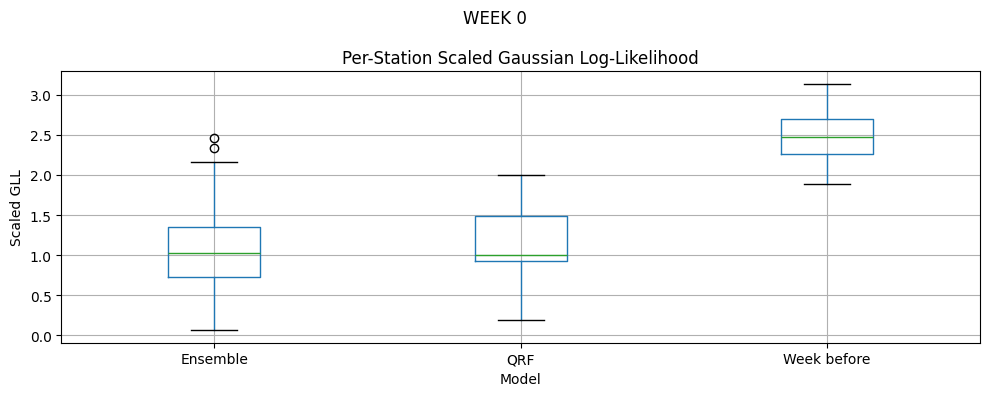

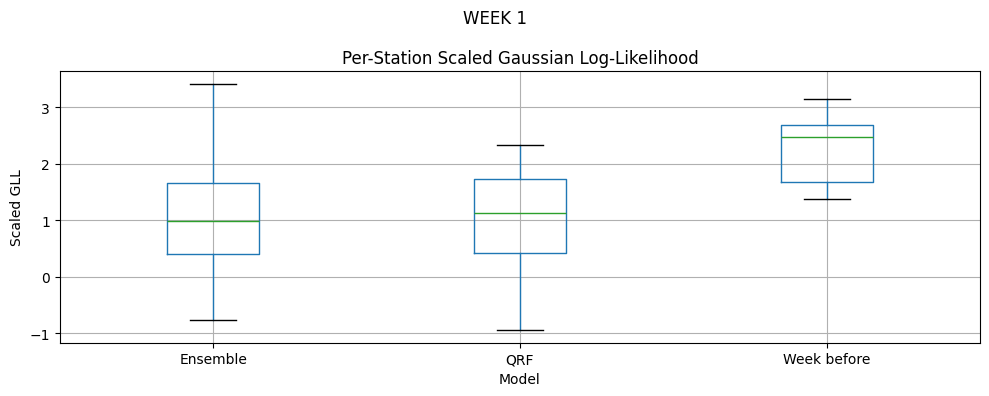

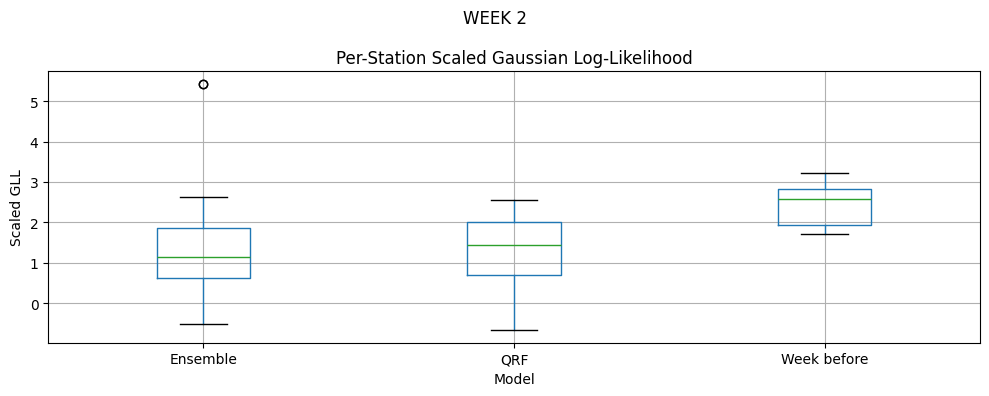

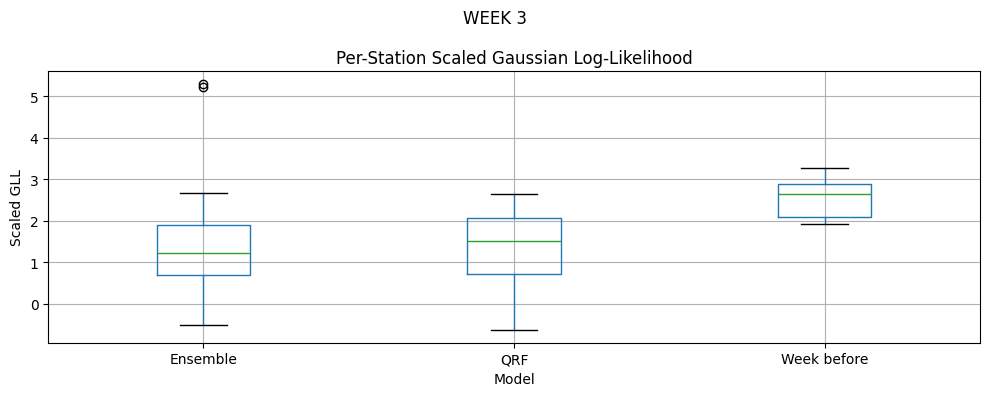

In [36]:
y_train_stations = dataset_train["station_code"].values

X_train_eval = X_train.drop(columns=["station_code"])
for i in range(NUMBER_OF_WEEK):
    predictions = []
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    predictions.append(
        {
            "model": "Week before",
            "prediction": baseline_day_before,
            "dataset": "train",
            "stations": y_train_stations,
            "prediction_interval": None,
        }
    )
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(
            X_train_eval, quantiles="mean", aggregate_leaves_first=False
        )
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA / 2, 1 - ALPHA / 2])

        predictions.append(
            {
                "model": "QRF",
                "prediction": y_pred_qrf,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_pis_qrf,
            }
        )
    if "ensemble" in FINAL_MODELS:
        ensemble_predictions = ensemble_models[i].predict(X_train_eval.fillna(0))
        ensemble_intervals = np.stack(
            [
                ensemble_predictions[:, 0],
                ensemble_predictions[:, 2],
            ],
            axis=1,
        )
        ensemble_predictions = ensemble_predictions[:, 1]

        predictions.append(
            {
                "model": "Ensemble",
                "prediction": ensemble_predictions,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": ensemble_intervals,
            }
        )

    compare_models_per_station(
        Y_train[i].values,
        predictions,
        y_train_stations,
        column_to_display="log_likelihood",
        title=f"WEEK {i}",
    )

### 4. Coverage on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [ ]:
for i in range(NUMBER_OF_WEEK):

    baseline_day_before = dataset_train["water_flow_lag_1w"]
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(
            X_train_eval, quantiles="mean", aggregate_leaves_first=False
        )
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA / 2, 1 - ALPHA / 2])
        coverage = (y_train[i].values >= y_pis_qrf[:, 0]) & (
            y_train[i].values <= y_pis_qrf[:, 1]
        )
        print(
            f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "ensemble" in FINAL_MODELS:
        print()

ValueError: operands could not be broadcast together with shapes (14532,) (27702,) 